In [97]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [98]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [100]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [101]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [102]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [104]:
# Create our session (link) from Python to the DB
session = Session(engine)
Base.metadata.create_all(engine)

# Exploratory Precipitation Analysis

In [105]:
#get column names for each table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [106]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [107]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent

('2017-08-23',)

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
most_recent =dt.date(2017, 8, 23)
start_date = most_recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date, Measurement.date <= most_recent).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = []
for result in results:
    data.append({'Date': result.date, 'Precipitation': result.prcp}) 
df = pd.DataFrame(data, columns=['Date','Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date', ascending=False).fillna(0.0)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

Precipitation
Date                     
2017-08-23           0.45
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-22           0.00

In [109]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = df['Precipitation'].describe()
precipitation_summary

count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: Precipitation, dtype: float64

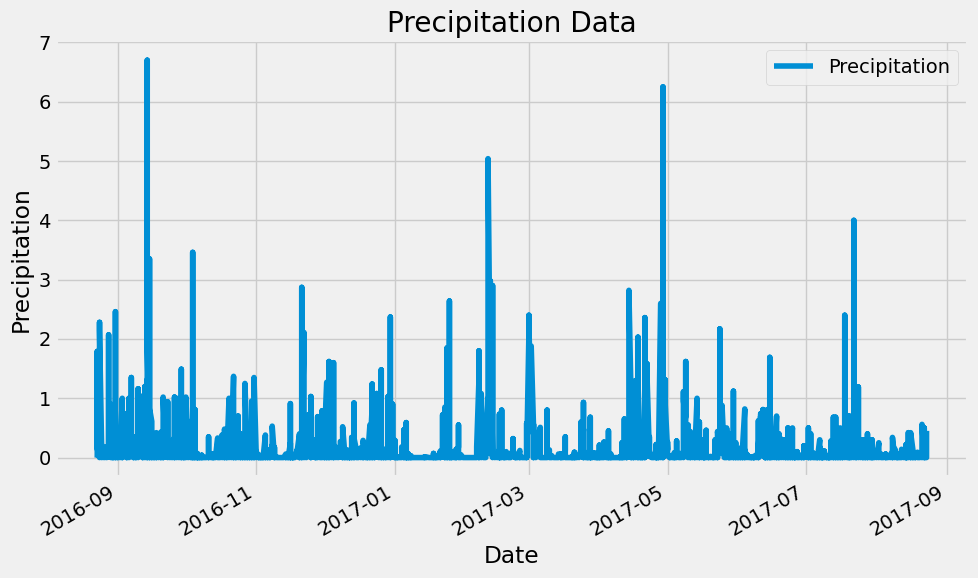

In [110]:
# Plot the data using Pandas' 
ax = df.plot(figsize=(10, 6))

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title('Precipitation Data')

# Show the plot
plt.tight_layout()
plt.show()


# Exploratory Station Analysis

station.columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

In [111]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print("Total number of stations:", total_stations)

Total number of stations: 9


In [112]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
print("Most active stations:")
for station, count in most_active:
    print(f"Station {station}: {count} rows")

Most active stations:
Station USC00519281: 2772 rows
Station USC00519397: 2724 rows
Station USC00513117: 2709 rows
Station USC00519523: 2669 rows
Station USC00516128: 2612 rows
Station USC00514830: 2202 rows
Station USC00511918: 1979 rows
Station USC00517948: 1372 rows
Station USC00518838: 511 rows


In [113]:
# Access the most active station and its count from the first tuple
most_active_station_count = most_active[0]

# Extract the station name (assuming it's the first element in the tuple)
most_active_station = most_active_station_count[0].strip()

# Print the most active station name
print("Most active station:", most_active_station)


Most active station: USC00519281


In [114]:
# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).first()

if temperature_stats:
    print(f"Temperature statistics for station" , most_active_station, ":")
    print(f"Lowest Temperature: {temperature_stats[0]}")
    print(f"Highest Temperature: {temperature_stats[1]}")
    print(f"Average Temperature: {temperature_stats[2]}")
else:
    print("No temperature statistics available for station", most_active_station)


Temperature statistics for station USC00519281 :
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [115]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yr_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station, Measurement.date >= start_date, Measurement.date <= most_recent).all()

# Extract temperature data into a list
temperatures = [temp for date, temp in yr_temps]
print("Date\tTemperature")
for date, temp in yr_temps:
    print(f"{date}\t{temp}")

Date	Temperature
2016-08-23	77.0
2016-08-24	77.0
2016-08-25	80.0
2016-08-26	80.0
2016-08-27	75.0
2016-08-28	73.0
2016-08-29	78.0
2016-08-30	77.0
2016-08-31	78.0
2016-09-01	80.0
2016-09-02	80.0
2016-09-03	78.0
2016-09-04	78.0
2016-09-05	78.0
2016-09-06	73.0
2016-09-07	74.0
2016-09-08	80.0
2016-09-09	79.0
2016-09-10	77.0
2016-09-11	80.0
2016-09-12	76.0
2016-09-13	79.0
2016-09-14	75.0
2016-09-15	79.0
2016-09-16	78.0
2016-09-17	79.0
2016-09-18	78.0
2016-09-19	78.0
2016-09-20	76.0
2016-09-21	74.0
2016-09-22	77.0
2016-09-23	78.0
2016-09-24	79.0
2016-09-25	79.0
2016-09-26	77.0
2016-09-27	80.0
2016-09-28	78.0
2016-09-29	78.0
2016-09-30	78.0
2016-10-01	77.0
2016-10-02	79.0
2016-10-03	79.0
2016-10-04	79.0
2016-10-05	79.0
2016-10-06	75.0
2016-10-07	76.0
2016-10-08	73.0
2016-10-09	72.0
2016-10-10	71.0
2016-10-11	77.0
2016-10-12	79.0
2016-10-13	78.0
2016-10-14	79.0
2016-10-15	77.0
2016-10-16	79.0
2016-10-17	77.0
2016-10-18	78.0
2016-10-19	78.0
2016-10-20	78.0
2016-10-21	78.0
2016-10-22	77.0
2016-10

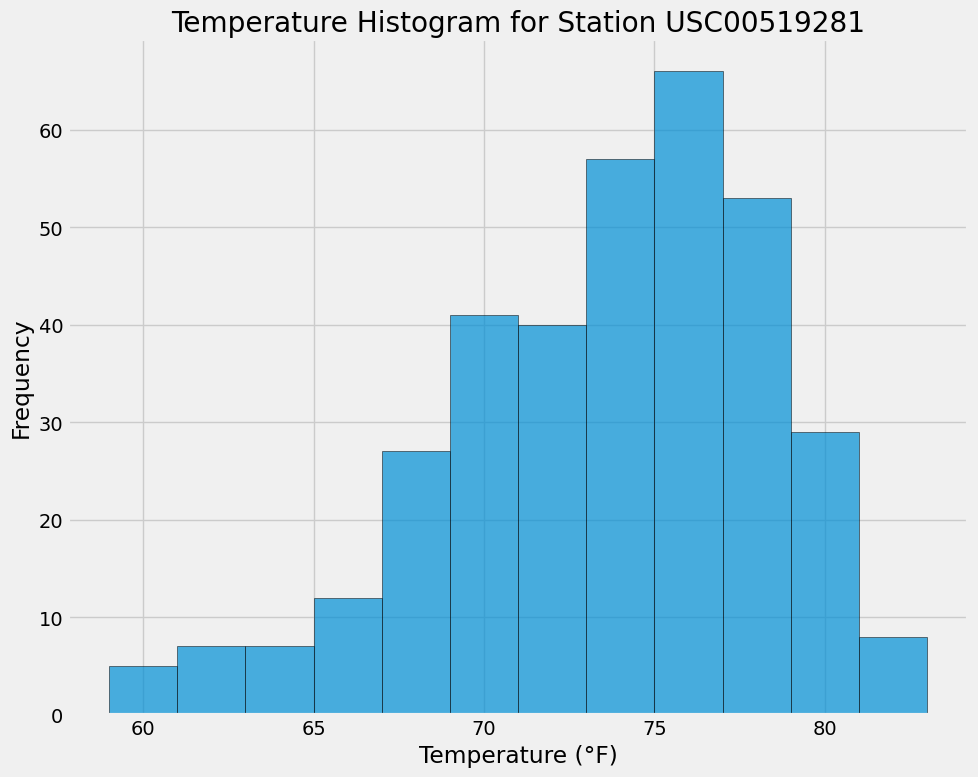

In [116]:


# Create a histogram using Matplotlib
plt.figure(figsize=(10, 8))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Histogram for Station ' + most_active_station)
plt.tight_layout()
plt.show()

# Close Session

In [117]:
# Close Session
session.close()